<a href="https://colab.research.google.com/github/d9249/DACON/blob/main/DenseNet161_epoch500_batchsize12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Oct 16 08:41:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -uq "/content/drive/MyDrive/DACON_CropsAreSick/sicks.zip"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader

In [5]:
train_total = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [20]:
device = torch.device("cuda:0")
batch_size = 12
class_n = len(train_total['disease_code'].unique())
learning_rate = 0.0001
epochs = 500
save_path = '/content/drive/MyDrive/DACON_CropsAreSick/DenseNet161_model.pt'

In [21]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        if mode == 'train':
            self.labels = labels
            
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        if self.mode == 'train':
            img = cv2.imread('./train_imgs/'+self.files[i])
            img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
            img = img.astype(np.float32)/255
            img = np.transpose(img, (2,0,1))
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'label' : torch.tensor(self.labels[i], dtype=torch.long)
            }
        else:
            img = cv2.imread('./test_imgs/'+self.files[i])
            img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
            img = img.astype(np.float32)/255
            img = np.transpose(img, (2,0,1))
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
            }

In [22]:
train = train_total.iloc[:200]
val = train_total.iloc[200:]

In [23]:
train_dataset = CustomDataset(train['img_path'].str.split('/').str[-1].values, train['disease_code'].values)
val_dataset = CustomDataset(val['img_path'].str.split('/').str[-1].values, val['disease_code'].values)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=16, shuffle=False)

test_dataset = CustomDataset(test['img_path'].str.split('/').str[-1], labels=None, mode='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=16, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [24]:
class CNN_Model(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Model, self).__init__()
        self.model = models.densenet161(pretrained=True)
        self.dropout = nn.Dropout(rate)
        self.output_layer = nn.Linear(in_features=1000, out_features=class_n, bias=True)
    
    def forward(self, inputs):
        output = self.output_layer(self.dropout(self.model(inputs)))
        return output

In [25]:
model = CNN_Model(class_n).to(device)

In [26]:
model.model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [30]:
def train_step(batch_item, epoch, batch, training):
    img = batch_item['img'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        return loss
    else:
        model.eval()
        with torch.no_grad():
            output = model(img)
            loss = criterion(output, label)
            
        return loss

In [31]:
loss_plot, val_loss_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    
    if np.min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model, save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
17it [00:12,  1.37it/s, Epoch=1, Loss=0.010114, Total Loss=0.016286]
5it [00:03,  1.52it/s, Epoch=1, Val Loss=0.009808, Total Val Loss=0.077210]
17it [00:12,  1.32it/s, Epoch=2, Loss=0.021133, Total Loss=0.010155]
5it [00:03,  1.56it/s, Epoch=2, Val Loss=0.013776, Total Val Loss=0.075214]
17it [00:12,  1.34it/s, Epoch=3, Loss=0.009640, Total Loss=0.007041]
5it [00:03,  1.54it/s, Epoch=3, Val Loss=0.010841, Total Val Loss=0.072923]
17it [00:12,  1.39it/s, Epoch=4, Loss=0.009084, Total Loss=0.007724]
5it [00:03,  1.51it/s, Epoch=4, Val Los

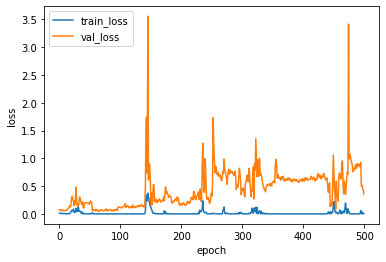

In [32]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [33]:
def predict(dataset):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    training = False
    results = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        with torch.no_grad():
            output = model(img)
        output = torch.tensor(torch.argmax(output, axis=-1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
    return results

In [34]:
preds = predict(test_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
396it [02:29,  2.64it/s]


In [35]:
submission = pd.read_csv('./sample_submission.csv')
submission.iloc[:,1] = preds
submission.to_csv('DenseNet161_epoch500_batchsize12.csv', index=False)

In [36]:
from google.colab import files

files.download('DenseNet161_epoch500_batchsize12.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>